# CocipGrid

This notebook demonstrates the `CocipGrid` model. This model computes CoCiP outputs over a grid of infinitesimal trajectory segments, each with nominal cruising characteristics.

In [1]:
import numpy as np

from pycontrails.datalib.ecmwf import ERA5
from pycontrails.models.cocipgrid import CocipGrid

## Met Data

See the `CoCiP.ipynb` notebook for details.

In [ ]:
time_bounds = ("2022-03-01 00:00:00", "2022-03-01 23:00:00")
pressure_levels = [300, 250, 200]

era5pl = ERA5(
    time=time_bounds,
    variables=CocipGrid.met_variables,
    pressure_levels=pressure_levels,
)
era5sl = ERA5(time=time_bounds, variables=CocipGrid.rad_variables)

met = era5pl.open_metdataset(wrap_longitude=True)
rad = era5sl.open_metdataset(wrap_longitude=True)

## Run grid model

Run with a single time and level input. Default resolution of longitude and latitude grid is one degree.

The output contains two data variables: `contrail_age` and `ef_per_m`.

In [3]:
model = CocipGrid(met=met.copy(), rad=rad.copy())
source = CocipGrid.create_source(level=250, time=time_bounds[0])
grid = model.eval(source)

/Users/marcus/computing/daitem/contrails/pycontrails/pycontrails/core/models.py:189: UserWarning: Met data appears to have originated from ECMWF and no humidity scaling is enabled. For ECMWF data, consider using one of 'ConstantHumidityScaling', 'ExponentialBoostHumidityScaling', or 'ExponentialBoostLatitudeCorrectionHumidityScaling'. For example: 
>>> from pycontrails.models import ConstantHumidityScaling
>>> Cocip(met=met, rad=rad, humidity_scaling=ConstantHumidityScaling(rhi_adj=0.99))
  warnings.warn(


CocipGrid eval:   0%|          | 0/65 [00:00<?, ?it/s]

In [4]:
ds = grid.data
ds.data_vars

Data variables:
    contrail_age  (longitude, latitude, level, time) float32 0.0 0.0 ... 0.0 0.0
    ef_per_m      (longitude, latitude, level, time) float64 0.0 0.0 ... 0.0 0.0

## Plot outputs

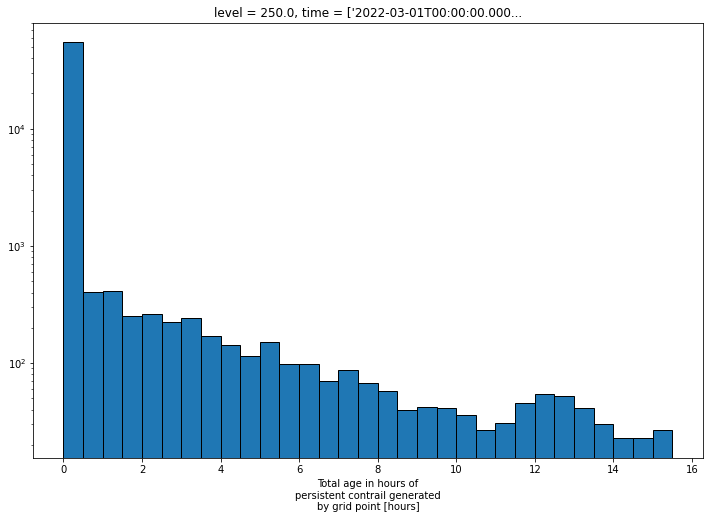

In [5]:
ds["contrail_age"].plot.hist(
    bins=np.arange(0, 16, 0.5),
    yscale="log",
    figsize=(12, 8),
    edgecolor="black",
);

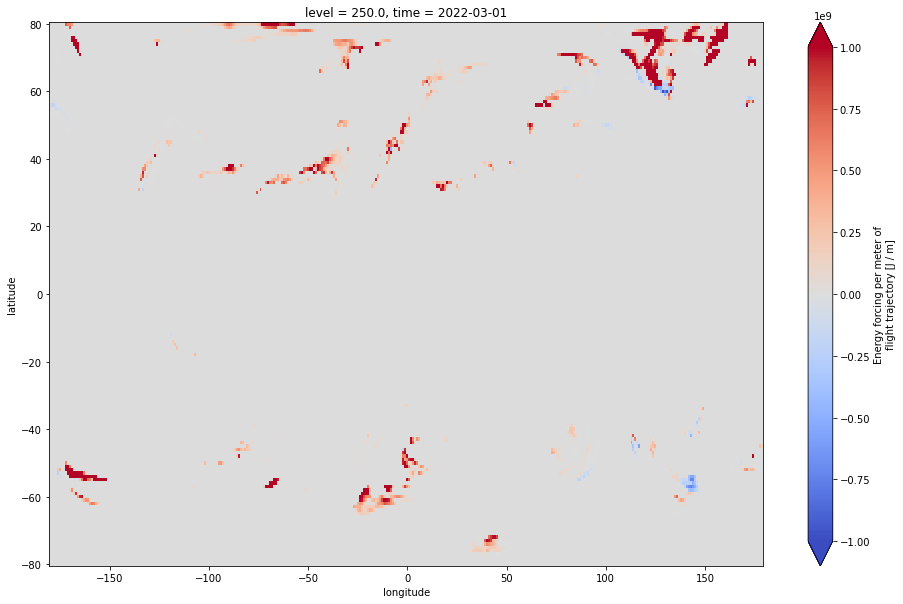

In [6]:
ds["ef_per_m"].plot(
    x="longitude",
    y="latitude",
    figsize=(16, 10),
    vmin=-1e9,
    vmax=1e9,
    cmap="coolwarm",
);

## Run grid with custom parameters

Change several of more significant model parameters.

- `azimuth`: the direction of each infinitesimal segment
- `aircraft_type`: derive aircraft characteristics according to this aircraft type
- `bada_priority`: select from BADA3 or BADA4
- `dt_integration`: time delta for advection step

In addition, we confine the longitude-latitude values to overlap the North Atlantic cooridor.

In [7]:
# CocipGrid parameters
params = {
    "azimuth": 45,
    "aircraft_type": "A320",
    "bada_priority": 3,
    "dt_integration": np.timedelta64(10, "m"),
}

# Grid coordinates
source = CocipGrid.create_source(
    longitude=np.arange(-75, 0, 0.5),
    latitude=np.arange(40, 70, 0.5),
    level=[240, 260, 280],
    time=[np.datetime64("2022-03-01T00"), np.datetime64("2022-03-01T01")],
)

# Downselecting met and rad to area of interest
bbox = -80, 35, 10, 75
met = met.downselect(bbox)
rad = rad.downselect(bbox)

# Run model
model = CocipGrid(
    met=met,
    rad=rad,
    params=params,
)
grid = model.eval(source)

/Users/marcus/computing/daitem/contrails/pycontrails/pycontrails/core/models.py:189: UserWarning: Met data appears to have originated from ECMWF and no humidity scaling is enabled. For ECMWF data, consider using one of 'ConstantHumidityScaling', 'ExponentialBoostHumidityScaling', or 'ExponentialBoostLatitudeCorrectionHumidityScaling'. For example: 
>>> from pycontrails.models import ConstantHumidityScaling
>>> Cocip(met=met, rad=rad, humidity_scaling=ConstantHumidityScaling(rhi_adj=0.99))
  warnings.warn(


CocipGrid eval:   0%|          | 0/166 [00:00<?, ?it/s]

/Users/marcus/computing/daitem/contrails/pycontrails/pycontrails/models/cocip/contrail_properties.py:423: UserWarning: All tau_contrail values are nan. This may be due to waypoints all lying outside of the met interpolation grid. It could indicate an issue with interpolation, or an insufficient met domain.
  warnings.warn(


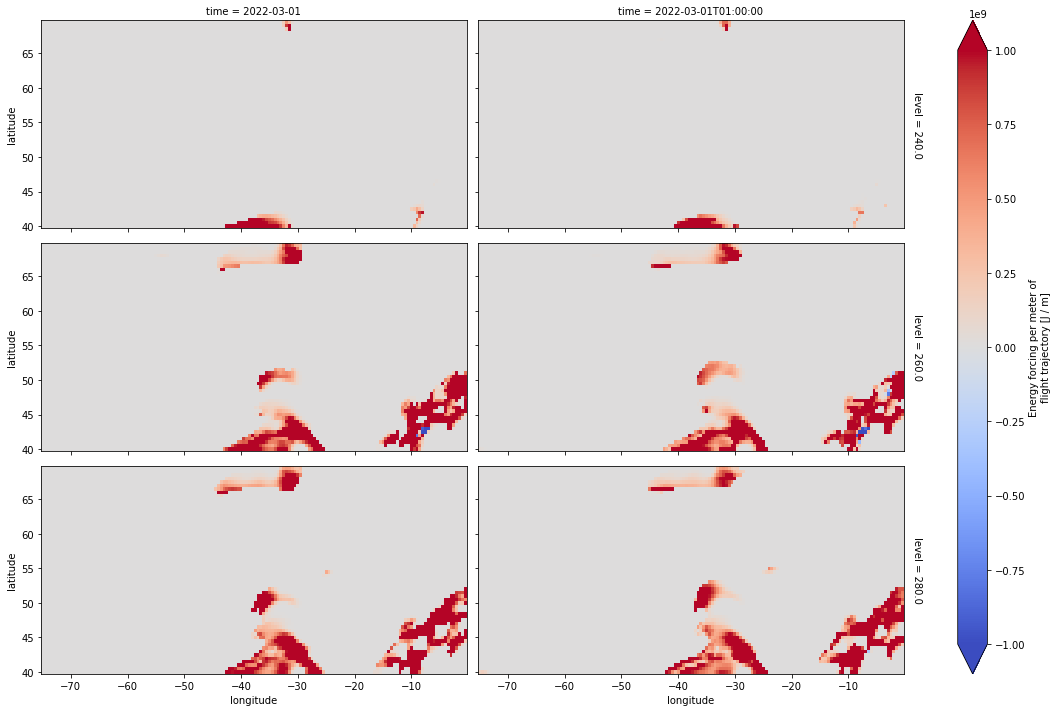

In [8]:
da = grid["ef_per_m"].data
da.plot(
    x="longitude",
    y="latitude",
    row="level",
    col="time",
    figsize=(16, 10),
    vmin=-1e9,
    vmax=1e9,
    cmap="coolwarm",
);